# Autoencoder

In dit notebook maken en trainen we een autoencoder voor de `mnist` dataset.
We gebruiken deze vervolgens om nieuw afbeeldingen van handgeschreven letters te genereren.

De code in dit voorbeeld is gebaseerd op de code uit hoofdstuk 3 van *Generative Deep Learning* van David Forester, O'Reilly Media, 2019 en op hoofdstuk 8 van *Deep Learning with Python* door François Chollet, Manning, 2018.

In [1]:
import numpy as np

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam

Using TensorFlow backend.


### verover de data

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
    
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

Afbeeldingen zijn 28x28 pixels in zwart/wit (1 kanaal).

We projecteren iedere afbeelding naar 2 getallen.

In [3]:
input_dim = (28, 28, 1)
z_dim = 2

### Encoder

We maken eerst een `encoder`. We maken hiervoor gebruik van de functionele notatie van Keras. De `encoder` is in essentie een CNN dat een afbeelding terugbrengt tot twee getallen.

In [4]:
encoder_input = Input(input_dim, name = 'encoder_input')

x = Conv2D(filters = 32,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_1')(encoder_input)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           strides = (2,2),
           padding = 'same',
           name = 'encoder_conv_2')(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           strides = (2,2),
           padding = 'same',
           name = 'encoder_conv_3')(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64,
           kernel_size = 3,
           padding = 'same',
           name = 'encoder_conv_4')(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

encoder_output = Dense(z_dim, name = 'encoder_output')(x)

encoder = Model(encoder_input, encoder_output)

Bestudeer bovenstaande code en maak vervolgens een `summary` van het model. Komt deze samenvatting overeen met jouw verwachtingen?

### Decoder

Nu maken we een `decoder`. Deze vertaalt een representatie bestaande uit twee getallen naar een afbeelding.
Hiervoor gebruiken we `Conv2DTranspose` lagen.

In [5]:
decoder_input = Input((z_dim,), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x) # van een dense vector naar de vorm van een afbeelding

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_1')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 64,
                kernel_size = 3,
                strides = (2,2),
                padding = 'same',
                name = 'decoder_conv_t_2')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 32,
                kernel_size = 3,
                strides = (2,2),
                padding = 'same',
                name = 'decoder_conv_t_3')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters = 1,
                kernel_size = 3,
                padding = 'same',
                name = 'decoder_conv_t_4')(x)
x = LeakyReLU()(x)

decoder_output = Activation('sigmoid')(x)

decoder = Model(decoder_input, decoder_output)

Bestudeer bovenstaande code en maak vervolgens een `summary`. Merk op dat de output van de laatste laag de afmetingen heeft van een afbeelding uit de `mnist` dataset. De `decoder` is een gespiegelde versie van de `encoder`, dit is echter niet noodzakelijk, de enige eis is dat het netwerk op basis van twee getallen een afbeelding kan genereren.

### De volledige autoencoder

De autoencoder koppelt de `encoder` en de `decoder`. Door deze samen te trainen en als loss functie de *mean squared error* tussen de originele afbeelding (input van de encoder) en de output van de decoder te nemen, optimaliseert de autoencoder de gewichten van beide onderdelen voor het reconstrueren van afbeeldingen.

In [6]:
autoencoder = Model(encoder_input, decoder(encoder_output))

Compileer en train de `autoencoder`.

In [7]:
learning_rate = 0.0005

optimizer = Adam(lr = learning_rate)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

autoencoder.compile(optimizer = optimizer, loss = r_loss)

Merk op dat in onderstaande code de labels gelijk zijn aan de inputs.

In [8]:
subset = 3000

autoencoder.fit(x = x_train[:subset], y = x_train[:subset], batch_size = 32, epochs = 20, shuffle = True)

Epoch 1/20
94/94 [==============================] - 4s 46ms/step - loss: 0.1302



### Reconstructie van originele afbeeldingen

Laten we nu eens kijken wat voor resultaten de `autoencoder` oplevert. Om te beginnen kijken we hoe goed de `decoder` in staat is om afbeeldingen te reconstrueren.

We selecteren willekeurige afbeeldingen uit de testset, coderen deze met de `encoder` en decoderen deze met de `decoder`.

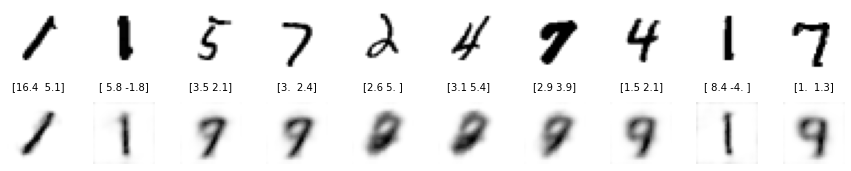

In [9]:
import matplotlib.pyplot as plt

n = 10

# selecteer willekeurige afbeeldingen uit x_test
idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[idx]

# vertaal met de encoder naar getallen
z_points = encoder.predict(test_images)

# vertaal de getallen met de decoder terug naar afbeeldingen
reconstr_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n):
    img = test_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')
    
for i in range(n):
    img = reconstr_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + n + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

Bovenstaande plot laat op de bovenste rij de originele afbeeldingen zien en daaronder telkens de door de decoder gereconstrueerde afbeelding.

Wat valt je op aan de reconstructies?

Om een beter beeld te krijgen van het gedrag van de autoencoder, plotten we de outputs van de encoder (de 'z-waarden') voor een deel van de testset. De kleur van een punt geeft het correcte label weer.

Daarnaast selecteren we alvast een aantal willekeurige punten (dus een combinatie van twee willekeurige getallen) die we dadelijk gaan gebruiken om volledig nieuwe afbeeldingen te genereren. Deze punten worden in het rood weergegeven.

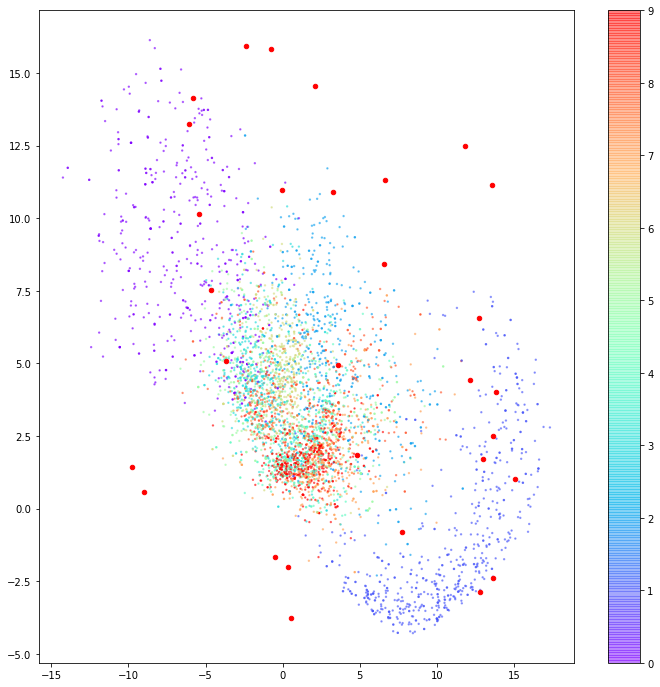

In [10]:
n = 5000
grid_size = 10
grid_depth = 3
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[example_idx]
test_labels = y_test[example_idx]

z_points = encoder.predict(test_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap = 'rainbow' , c = test_labels, alpha = 0.5, s = 2)
plt.colorbar()

# willekeurige punten
x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

Wat valt je op aan bovenstaande plot met betrekking tot de verdeling van de labels?

Wat valt je op aan bovenstaande plot met betrekking tot de willekeurig geselecteerde punten?

We gebruiken nu de `decoder` om op basis van de willekeurig gegenereerde punten volledig nieuwe afbeeldingen te genereren en plotten deze afbeeldingen.

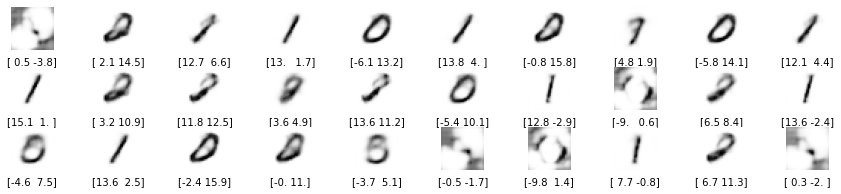

In [11]:
reconst = decoder.predict(z_grid)

figsize = 15
fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

Wat valt je op aan deze afbeeldingen?

Varieer nu eens met het aantal lagen en filters in de `encoder` en `decoder`. Kun je de `decoder` een volledig andere vorm geven dan de `encoder`? Hoe beïnvloed dit het resultaat?